# 2부. 실전편 ⓵ 머신러닝
## 03장. 고객의 전체 모습을 파악하는 테크닉 10제

## 📣 고객의 소리
제가 운영하는 스포츠 센터는 트레이닝 붐 덕분에 지금까지 고객 수가 늘었습니다.

그런데, 최근 1년간 고객 수가 늘지 않는 것 같습니다. 


자주 이용하는 고객은 계속 오지만, 가끔 오는 고객은 어느새 오지 않는 경우도 생기는 것 같습니다.

제대로 데이터를 분석한 적이 없어서 어떤 고객이 계속 이용하고 있는지조차 모릅니다. 

데이터 분석을 하면 뭔가 알 수 있을까요?
<br>

## 📍 전제조건

30개의 테크닉을 이용해서 스포츠 센터 데이터를 다루게 된다.

스포츠 센터에는,

① 센터를 언제든 사용할 수 있는 종일 회원

② 낮에만 사용할 수 있는 주간회원

③ 밤에만 사용할 수 있는 야간회원

3종류의 회원으로 구분되고 있다. 또한, 일반적으로 입회비가 들지만, 비정기적으로 입회비 반액 할인이나 입회비 무료행사를 통해 신규회원을 늘리고 있다.

탈퇴하려면 월말까지 신청하면 그 다음 달 말에 탈퇴가 된다.

<br> 

여기서 취급할 데이터는 4종류인데,

① use_log.csv => 센터 이용 이력(회원이 센터를 이용하면 이용일이 시스템에 자동 입력됨., 2018.04 ~ 2019.03 까지 데이터)

② customer_master.csv => 2019년 3월말 시점의 회원 데이터이며, 이전에 탈퇴한 회원 역시 포함

③ class_master.csv => 회원 구분 데이터

④ campaign_master.csv => 가입 시 행사 종류 데이터

In [1]:

import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook
from IPython.core.display import display, HTML  # 화면크기 조절
display(HTML("<style>.container { width: 75% !important; }</style>"))

import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential

### 021. 데이터를 읽어 들이고 확인하자

In [2]:

# 센터 이용 이력
uselog = pd.read_csv("/Users/jeongjihwan/Downloads/pyda100-master/3장/use_log.csv")
print(len(uselog))
uselog.head()

197428


,log_id,customer_id,usedate
0,L00000049012330,AS009373,2018-04-01
1,L00000049012331,AS015315,2018-04-01
2,L00000049012332,AS040841,2018-04-01
3,L00000049012333,AS046594,2018-04-01
4,L00000049012334,AS073285,2018-04-01


In [3]:

# 2019년 3월말 시점의 회원 데이터
customer = pd.read_csv("/Users/jeongjihwan/Downloads/pyda100-master/3장/customer_master.csv")
print(len(customer))
customer.head()

4192


,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted
0,OA832399,XXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0
1,PL270116,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0
2,OA974876,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0
3,HD024127,XXXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0
4,HD661448,XXXXX,C03,F,2015-05-01 00:00:00,NaN,CA1,0


* 개인 이름의 경우 마스킹돼 있어서 이름만으로 개인을 특정 지을 수 없음

In [4]:

# 회원 구분 데이터
class_master = pd.read_csv("/Users/jeongjihwan/Downloads/pyda100-master/3장/class_master.csv")
print(len(class_master))
class_master.head()

3


,class,class_name,price
0,C01,0_종일,10500
1,C02,1_주간,7500
2,C03,2_야간,6000


In [5]:

# 가입 시 행사 종류 데이터
campaign_master = pd.read_csv("/Users/jeongjihwan/Downloads/pyda100-master/3장/campaign_master.csv")
print(len(campaign_master))
campaign_master.head()

3


,campaign_id,campaign_name
0,CA1,2_일반
1,CA2,0_입회비반액할인
2,CA3,1_입회비무료


### 022. 고객 데이터를 가공하자

* 분석을 위해서 기준 데이터를 선정하고 가공을 해야한다.


* uselog 와 customer 데이터셋이 기준 데이터셋이 될 수 있는데, 일단 먼저 데이터 수가 적은 고객 데이터를 메인으로 진행해보자

In [6]:

customer_join = pd.merge(customer, class_master, how="left", on="class")
customer_join = pd.merge(customer_join, campaign_master, how="left", on="campaign_id")
print(len(customer_join))
customer_join.head()

4192


,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name
0,OA832399,XXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0,0_종일,10500,2_일반
1,PL270116,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0,0_종일,10500,2_일반
2,OA974876,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0,0_종일,10500,2_일반
3,HD024127,XXXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0,0_종일,10500,2_일반
4,HD661448,XXXXX,C03,F,2015-05-01 00:00:00,NaN,CA1,0,2_야간,6000,2_일반


In [7]:

customer_join.isnull().sum()

customer_id         0
name                0
class               0
gender              0
start_date          0
end_date         2842
campaign_id         0
is_deleted          0
class_name          0
price               0
campaign_name       0
dtype: int64

* 탈퇴하지 않은 회원의 탈퇴일이 공백으로 표시돼서 그런 것임.

### 023. 고객 데이터를 집계하자

In [8]:

customer_join.groupby("class_name").count()['customer_id']

class_name
0_종일    2045
1_주간    1019
2_야간    1128
Name: customer_id, dtype: int64

* 종일반이 거의 절반을 차지

In [9]:

customer_join.groupby("campaign_name").count()['customer_id']

campaign_name
0_입회비반액할인     650
1_입회비무료       492
2_일반         3050
Name: customer_id, dtype: int64

* 입회 캠페인에 의한 가입이 약 20% ?

In [10]:
(3050 / (650  + 492 + 3050)) * 100

72.75763358778626

In [11]:

customer_join.groupby("gender").count()['customer_id']

gender
F    1983
M    2209
Name: customer_id, dtype: int64

In [12]:

customer_join.groupby("is_deleted").count()['customer_id']

is_deleted
0    2842
1    1350
Name: customer_id, dtype: int64

* 0이 탈퇴하지 않은 고객의 수

In [13]:

# start_date가 2018년 4월 1일 이후부터 2019년 3월 31일까지 가입 인원
customer_join["start_date"] = pd.to_datetime(customer_join["start_date"])
customer_start = customer_join.loc[customer_join["start_date"] > pd.to_datetime("20180401")]
print(len(customer_start))

1361


* 즉, 이 기간 동안의 가입인원이 1361명인 것.

In [14]:
customer_start

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name
2831,HI195873,XXX,C01,F,2018-04-02,2018-08-31 00:00:00,CA3,1,0_종일,10500,1_입회비무료
2832,TS322485,XX,C03,F,2018-04-02,2018-08-31 00:00:00,CA3,1,2_야간,6000,1_입회비무료
2833,IK552971,XXXXX,C02,F,2018-04-02,2018-08-31 00:00:00,CA3,1,1_주간,7500,1_입회비무료
2834,PL000560,XXX,C01,M,2018-04-02,2018-07-31 00:00:00,CA3,1,0_종일,10500,1_입회비무료
2835,HD218970,XXXXX,C01,F,2018-04-02,2018-11-30 00:00:00,CA3,1,0_종일,10500,1_입회비무료
...,...,...,...,...,...,...,...,...,...,...,...
4187,HD676663,XXXX,C01,M,2019-03-14,NaN,CA1,0,0_종일,10500,2_일반
4188,HD246549,XXXXX,C01,F,2019-03-14,NaN,CA1,0,0_종일,10500,2_일반
4189,GD037007,XXXXX,C03,M,2019-03-14,NaN,CA1,0,2_야간,6000,2_일반
4190,OA953150,XXXXX,C01,M,2019-03-14,NaN,CA1,0,0_종일,10500,2_일반


### 024. 최신 고객 데이터를 집계하자 

In [15]:

customer_join["end_date"] = pd.to_datetime(customer_join["end_date"]) 
customer_newer = customer_join.loc[(customer_join["end_date"] >= pd.to_datetime("20190331")) | (customer_join["end_date"].isna())]
print(len(customer_newer))
customer_newer["end_date"].unique()

2953


array([                          'NaT', '2019-03-31T00:00:00.000000000'],
      dtype='datetime64[ns]')

* NaT는 datetime형의 결측치를 의미함.
* 2953명은 즉, 아직 탈퇴하지 않은 고객의 수를 의미.

In [16]:

customer_newer.groupby("class_name").count()["customer_id"]

class_name
0_종일    1444
1_주간     696
2_야간     813
Name: customer_id, dtype: int64

In [17]:

customer_newer.groupby("campaign_name").count()["customer_id"]

campaign_name
0_입회비반액할인     311
1_입회비무료       242
2_일반         2400
Name: customer_id, dtype: int64

In [18]:
(2400 / (311 + 242 + 2400)) * 100

81.27328140873688

* 023 내용과 비교하면, 회원구분이나 성별에서는 이전과 차이가 없는 걸 봐서 해당 요인이 탈퇴한 고객으로 볼 수 는 없는 것 같다.


* 캠페인 구분에서는 약간의 차이를 보이는데, 아직 탈퇴하지 않은 일반 입회 회원 비율이 81%로 변경됨 (일반 보다 나머지 캠페인과 관련된 고객들이 더 많이 탈퇴한 듯)

In [19]:

customer_newer.groupby("gender").count()["customer_id"]

gender
F    1400
M    1553
Name: customer_id, dtype: int64

### 025. 이용 이력 데이터를 집계하자

* 이용 이력 데이터는 고객 데이터와 다르게, 시간적 요소를 분석할 수 있음

In [20]:

uselog["usedate"] = pd.to_datetime(uselog["usedate"])
uselog["연월"] = uselog["usedate"].dt.strftime("%Y%m")
uselog_months = uselog.groupby(["연월", "customer_id"], as_index=False).count()
uselog_months.rename(columns={"log_id": "count"}, inplace=True)

del uselog_months["usedate"]  # 칼럼 삭제
uselog_months.head()

,연월,customer_id,count
0,201804,AS002855,4
1,201804,AS009013,2
2,201804,AS009373,3
3,201804,AS015315,6
4,201804,AS015739,7


* 고객별 월 이용 횟수를 집계한 데이터

In [21]:

uselog_customer = uselog_months.groupby("customer_id").agg(["mean", "median", "max", "min"])["count"]
uselog_customer = uselog_customer.reset_index(drop=False)  # 기존 인덱스를 첫번째 칼럼으로 처리
uselog_customer.head()

,customer_id,mean,median,max,min
0,AS002855,4.500000,5.0,7,2
1,AS008805,4.000000,4.0,8,1
2,AS009013,2.000000,2.0,2,2
3,AS009373,5.083333,5.0,7,3
4,AS015233,7.545455,7.0,11,4



* 월별 데이터에 대한 고객별 이용횟수의 평균값, 중앙값, 최댓값, 최솟값 집계

### 026. 이용 이력 데이터로부터 정기 이용 플래그를 작성하자

In [22]:
uselog["usedate"].dt.weekday

0         6
1         6
2         6
3         6
4         6
         ..
197423    6
197424    6
197425    6
197426    6
197427    6
Name: usedate, Length: 197428, dtype: int64

* `월화수목금토일` -> 0 ~ 6으로 리턴

In [23]:

uselog["weekday"] = uselog["usedate"].dt.weekday
uselog_weekday = uselog.groupby(["customer_id", "연월", "weekday"], as_index=False).count()[["customer_id", "연월", "weekday", "log_id"]]
uselog_weekday.rename(columns={"log_id": "count"}, inplace=True)
uselog_weekday.head()

,customer_id,연월,weekday,count
0,AS002855,201804,5,4
1,AS002855,201805,2,1
2,AS002855,201805,5,4
3,AS002855,201806,5,5
4,AS002855,201807,1,1


In [24]:

uselog_weekday = uselog_weekday.groupby("customer_id", as_index=False).max()[["customer_id", "count"]]
uselog_weekday["routine_flg"] = 0
uselog_weekday["routine_flg"] = uselog_weekday["routine_flg"].where(uselog_weekday["count"] < 4, 1)  # 즉 4이상이면 1을 대입
uselog_weekday.head()

,customer_id,count,routine_flg
0,AS002855,5,1
1,AS008805,4,1
2,AS009013,2,0
3,AS009373,5,1
4,AS015233,5,1


* np.where(배열에 대한 조건문, 참일때 값, 거짓일때 값)
<br>

* Series객체1.where(Series객체에 대한 조건문, 거짓 값에 대한 대체 값)

넘파이와 판다스에서 where 함수에서의 차이가 있음

참고: https://yganalyst.github.io/data_handling/memo_3/

### 027. 고객 데이터와 이용 이력 데이터를 결합하자

* 고객 데이터와 결합을 통해 최대 이력을 포함한 고객 데이터를 수정

In [25]:

customer_join = pd.merge(customer_join, uselog_customer, how="left", on="customer_id")
customer_join = pd.merge(customer_join, uselog_weekday[["customer_id", "routine_flg"]], how="left", on="customer_id")
customer_join.head()

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,routine_flg
0,OA832399,XXXX,C01,F,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,4.833333,5.0,8,2,1
1,PL270116,XXXXX,C01,M,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,5.083333,5.0,7,3,1
2,OA974876,XXXXX,C01,M,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,4.583333,5.0,6,3,1
3,HD024127,XXXXX,C01,F,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,4.833333,4.5,7,2,1
4,HD661448,XXXXX,C03,F,2015-05-01,NaT,CA1,0,2_야간,6000,2_일반,3.916667,4.0,6,1,1


In [26]:

# 결측치 확인
customer_join.isnull().sum()

customer_id         0
name                0
class               0
gender              0
start_date          0
end_date         2842
campaign_id         0
is_deleted          0
class_name          0
price               0
campaign_name       0
mean                0
median              0
max                 0
min                 0
routine_flg         0
dtype: int64

* end_date는 아직 이탈하지 않는 고객이므로 무시해도 됨

### 028. 회원 기간을 계산하자

* 월 단위로 start_date 부터 탈퇴한 시점까지 회원기간 집계

In [27]:
customer_join["start_date"]

0      2015-05-01
1      2015-05-01
2      2015-05-01
3      2015-05-01
4      2015-05-01
          ...    
4187   2019-03-14
4188   2019-03-14
4189   2019-03-14
4190   2019-03-14
4191   2019-03-15
Name: start_date, Length: 4192, dtype: datetime64[ns]

In [28]:

# dateutil 패키지 안에 있는 relativedelta 모듈
from dateutil.relativedelta import relativedelta  # 날짜 비교해주는 relativedelta 클래스
customer_join["calc_date"] = customer_join["end_date"]
customer_join["calc_date"] = customer_join["calc_date"].fillna(pd.to_datetime("20190430"))
customer_join["membership_period"] = 0
for i in range(len(customer_join)):
    delta = relativedelta(customer_join["calc_date"].iloc[i], customer_join["start_date"].iloc[i])
    customer_join["membership_period"].iloc[i] = delta.years*12 + delta.months

customer_join.head()  

/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period
0,OA832399,XXXX,C01,F,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,4.833333,5.0,8,2,1,2019-04-30,47
1,PL270116,XXXXX,C01,M,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,5.083333,5.0,7,3,1,2019-04-30,47
2,OA974876,XXXXX,C01,M,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,4.583333,5.0,6,3,1,2019-04-30,47
3,HD024127,XXXXX,C01,F,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,4.833333,4.5,7,2,1,2019-04-30,47
4,HD661448,XXXXX,C03,F,2015-05-01,NaT,CA1,0,2_야간,6000,2_일반,3.916667,4.0,6,1,1,2019-04-30,47


In [29]:

relativedelta(customer_join["calc_date"].iloc[0], customer_join["start_date"].iloc[0])

relativedelta(years=+3, months=+11, days=+29)

In [30]:
relativedelta(customer_join["calc_date"].iloc[0], customer_join["start_date"].iloc[0]).years

3

### 029. 고객 행동의 각종 통계량을 파악하자

In [31]:

customer_join.describe()[["mean", "median", "max", "min"]]

,mean,median,max,min
count,4192.000000,4192.000000,4192.000000,4192.000000
mean,5.333127,5.250596,7.823950,3.041269
std,1.777533,1.874874,2.168959,1.951565
min,1.000000,1.000000,1.000000,1.000000
25%,4.250000,4.000000,7.000000,2.000000
50%,5.000000,5.000000,8.000000,3.000000
75%,6.416667,6.500000,9.000000,4.000000
max,12.000000,12.000000,14.000000,12.000000


In [32]:

customer_join.groupby("routine_flg").count()["customer_id"]

routine_flg
0     779
1    3413
Name: customer_id, dtype: int64

* 정기적으로 이용하는 고객 수가 더 많다.

(array([857., 774., 395., 368., 311., 331., 323., 237., 288., 308.]),
 array([ 1. ,  5.6, 10.2, 14.8, 19.4, 24. , 28.6, 33.2, 37.8, 42.4, 47. ]),
 <BarContainer object of 10 artists>)

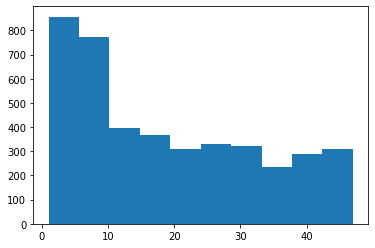

In [33]:

plt.hist(customer_join["membership_period"])

* 즉, 회원 기간이 10개월 이내인 고객이 많은 스포츠 센터이며, 10개월 이상 넘어가는 고객 수는 거의 유사하게 분포



* 짧은 기간에 고객이 빠져나가는 업계인 듯. (위치, 시설, 혜택 등 다른 요인들을 생각해볼 수가 있겠다..)

### 030. 탈퇴 회원과 지속 회원의 차이를 파악하자

* 023에서 집계한 탈퇴 회원과 지속 회원의 수는 각각 1,350명 2,842명

In [34]:

customer_end = customer_join.loc[customer_join["is_deleted"] == 1]
customer_end.describe()

,is_deleted,price,mean,median,max,min,routine_flg,membership_period
count,1350.0,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000
mean,1.0,8595.555556,3.865474,3.621852,6.461481,1.821481,0.456296,8.026667
std,0.0,1949.163652,1.246385,1.270847,2.584021,0.976361,0.498271,5.033692
min,1.0,6000.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
25%,1.0,6000.000000,3.000000,3.000000,4.000000,1.000000,0.000000,4.000000
50%,1.0,7500.000000,4.000000,4.000000,7.000000,2.000000,0.000000,7.000000
75%,1.0,10500.000000,4.666667,4.500000,8.000000,2.000000,1.000000,11.000000
max,1.0,10500.000000,9.000000,9.000000,13.000000,8.000000,1.000000,23.000000


* 탈퇴 회원

In [35]:

customer_stay = customer_join.loc[customer_join["is_deleted"] == 0]
customer_stay.describe()

,is_deleted,price,mean,median,max,min,routine_flg,membership_period
count,2842.0,2842.000000,2842.000000,2842.000000,2842.000000,2842.000000,2842.000000,2842.000000
mean,0.0,8542.927516,6.030288,6.024279,8.471147,3.620690,0.984166,23.970443
std,0.0,1977.189779,1.553587,1.599765,1.571048,2.030488,0.124855,13.746761
min,0.0,6000.000000,3.166667,3.000000,5.000000,1.000000,0.000000,1.000000
25%,0.0,6000.000000,4.833333,5.000000,7.000000,2.000000,1.000000,12.000000
50%,0.0,7500.000000,5.583333,5.500000,8.000000,3.000000,1.000000,24.000000
75%,0.0,10500.000000,7.178030,7.000000,10.000000,5.000000,1.000000,35.000000
max,0.0,10500.000000,12.000000,12.000000,14.000000,12.000000,1.000000,47.000000


* 지속 회원


* 각 mean 칼럼 (고객의 매월 평균 이용 횟수)을 비교하면 확실히 평균값과 중앙값은 약 1.5배 차이가 나고 있다.
* 정기적으로 이용하고 있는지 여부를 파악하는 routine_flg 칼럼의 경우, 평균값을 보면 탈퇴회원은 0.46  지속회원은 0.98 정도

In [36]:

customer_join.to_csv("customer_join.csv", index=False)